In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
os.listdir('data')

['savingacct_txn.csv',
 'creditcard_txn.csv',
 'cust_past1year_snapshot.xlsx',
 'cust.csv',
 'currentacct_txn.csv',
 'cust_dna.csv',
 'cust_prev.csv']

In [6]:
dir_prev = 'data/cust.csv'
dir_cur = 'data/cust_prev.csv'

def read_df_comb(dir_prev, dir_cur):
    df_cur = pd.read_csv(dir_prev)
    df_cur['BE_SEGMENT'] = df_cur['BE_SEGMENT'].str[0].fillna(-1).astype('int')
    df_prev = pd.read_csv(dir_cur)

    df_comb = df_prev.merge(df_cur, on='id', suffixes=['_prev', '_cur'], how='outer')
    df_comb = df_comb[df_comb['BE_SEGMENT_prev'] != -1]
    df_comb['be_segment_p1m'] = df_comb['BE_SEGMENT_cur']

    df_comb = df_comb[(df_comb[['be_segment_p{}m'.format(i) for i in range(1, 13)]] > 0).all(axis=1)]

    def ols(df):
        X = pd.DataFrame([i for i in range(1, 13)])
        y = df[['be_segment_p{}m'.format(i) for i in range(12, 0, -1)]].T
        reg = LinearRegression().fit(X, y.astype(int))
        return reg.coef_[0]

    df_comb['segment_slope'] = df_comb.apply(lambda x: ols(x), axis=1)
    
    return df_comb

# read_df_comb(dir_prev, dir_cur)

In [7]:
df_cur = pd.read_csv('data/cust.csv')
df_cur['BE_SEGMENT'] = df_cur['BE_SEGMENT'].str[0].fillna(-1).astype('int')
df_prev = pd.read_csv('data/cust_prev.csv')

df_comb = df_prev.merge(df_cur, on='id', suffixes=['_prev', '_cur'], how='outer')
df_comb = df_comb[df_comb['BE_SEGMENT_prev'] != -1]
df_comb['be_segment_p1m'] = df_comb['BE_SEGMENT_cur']

df_comb = df_comb[(df_comb[['be_segment_p{}m'.format(i) for i in range(1, 13)]] > 0).all(axis=1)]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
df_comb.groupby(['BE_SEGMENT_prev']).count()[['id']]

,id
BE_SEGMENT_prev,
1,72
2,3579
3,5183
4,808


### Weigh current segment

compute 1 year changes
- Parameter: alpha

In [9]:
alpha = 0.2
df_comb['BE_SEGMENT_weighted'] = 0
for i in range(1, 13):
    colname = 'be_segment_p{}m'.format(i)
    df_comb['BE_SEGMENT_weighted'] += alpha ** (i - 1) * df_comb[colname]

df_comb['segment_diff'] = df_comb['BE_SEGMENT_prev'] - df_comb['BE_SEGMENT_cur']
df_comb['segment_diff_weighted'] = df_comb['BE_SEGMENT_prev'] - df_comb['BE_SEGMENT_weighted']

Difference between weigh and not weighing
- Mode (likely) is the value given there's no change throughout the months, this can be the baseline

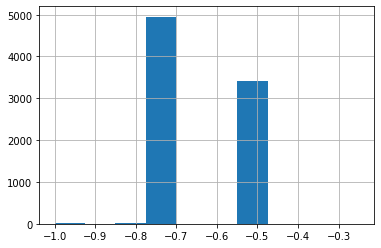

In [10]:
_ = df_comb[df_comb['segment_diff'] == 0]['segment_diff_weighted'].hist()

Response variable: `segment_diff_weighted`
- High score -> changing towards affluence
- account for noises
- A little vague on the actual meaning
    - small increase/decrease indicates changes during the past months
- Less suitable for decision tree (?)

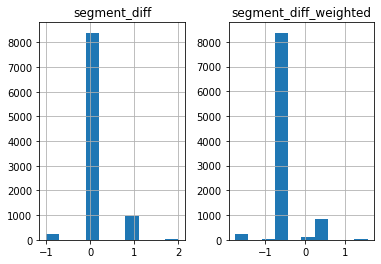

In [11]:
_ = (df_comb[['segment_diff', 'segment_diff_weighted']]).hist()

### Regress response

In [15]:
def ols(df):
    X = pd.DataFrame([i for i in range(1, 13)])
    y = df[['be_segment_p{}m'.format(i) for i in range(12, 0, -1)]].T
    reg = LinearRegression().fit(X, y.astype(int))
    return reg.coef_[0]

df_comb['segment_slope'] = df_comb.apply(lambda x: ols(x), axis=1)

In [18]:
df_comb[['segment_slope', 'BE_SEGMENT_prev']].groupby('BE_SEGMENT_prev').mean()

,segment_slope
BE_SEGMENT_prev,
1,0.087898
2,0.002696
3,-0.002829
4,-0.073859


<AxesSubplot:>

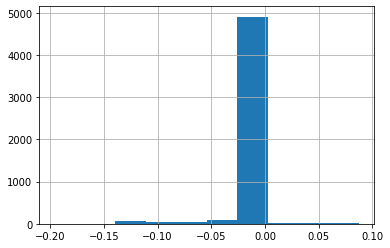

In [20]:
df_comb[df_comb['BE_SEGMENT_prev'] == 3]['segment_slope'].hist()

# Markov Model

In [110]:
# 'be_segment_p{}m'.format(i)
ls = []
for i in range(1, 12):
    ls.append(df_comb[['be_segment_p{}m'.format(i), 'be_segment_p{}m'.format(i + 1)]])
    ls[-1].columns = ['prev', 'cur']
df_trans = pd.concat(ls, axis=0)
df_trans = df_trans[(df_trans['prev'] != -1) & (df_trans['cur'] != -1)]

trans_mat = np.zeros((4, 4))
for a, b in zip(df_trans['prev'], df_trans['cur']):
    trans_mat[a - 1, b - 1] += 1
    
prev_sums = df_trans.groupby('prev').count().sort_index()['cur']
prev_sums = np.expand_dims(np.array(prev_sums), 1).repeat(4, axis=1)

trans_mat = trans_mat / prev_sums

p_init = prev_sums[:, 0] / len(df_trans)

In [340]:
trans_states = [p_init]
for _ in range(2000):
    trans_states.append(trans_states[-1] @ trans_mat)

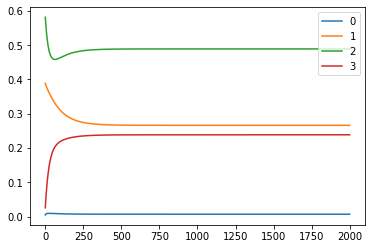

In [341]:
state_distributions = pd.DataFrame(trans_states)
state_distributions
state_distributions.plot();

# Customer Personal Info

In [416]:
df_dna = pd.read_csv('data/cust_dna.csv')
df_dna = df_dna.merge(df_comb[['id'] + cols_resp], on='id', how='right')

In [417]:
cols_cust = ['FRST_CONT_DT', 'CUST_AGE', 'SEX', 'MARITAL_STATUS', 'D_OCC']
cols_cust_dna = ['cd_age', 'cd_dependent_cnt', 'cd_mrtl_status', 
                 'cd_premier_cust_flg', 'cd_resident_flg', 'cd_state', 'cd_race', 
                 'cd_salary_amt', 'cd_risk_cd', 'cd_education']

cols_resp = ['segment_diff_weighted', 'segment_diff', 'BE_SEGMENT_prev', 'BE_SEGMENT_weighted', 'BE_SEGMENT_cur']

df_cust_eda = df_comb[[x + '_prev' for x in cols_cust] + cols_resp]
df_eda_dna = df_eda_dna[cols_cust_dna + cols_resp]

In [496]:
# tmp = pd.to_datetime(df_cust_eda['FRST_CONT_DT_prev'])
# plt.scatter(tmp, df_cust_eda['segment_diff_weighted'], alpha=0.1)

# tmp = df_cust_eda[['MARITAL_STATUS_prev', 'segment_diff_weighted']]
# tmp.loc[tmp['MARITAL_STATUS_prev'].isin(['Divorced', 'Widowed']), 'MARITAL_STATUS_prev'] = 'Divorced/Widowed'
# tmp.loc[tmp['MARITAL_STATUS_prev'] == '', 'MARITAL_STATUS_prev'] = 'Unknown'
# tmp.boxplot('segment_diff_weighted', 'MARITAL_STATUS_prev')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BE_SEGMENT_prev
cd_mrtl_status,
,1
Divorced,52
Divorced/W,4
Married,4849
Others,126
Separated,2
Single,4592
Unknown,5
Widowed,21


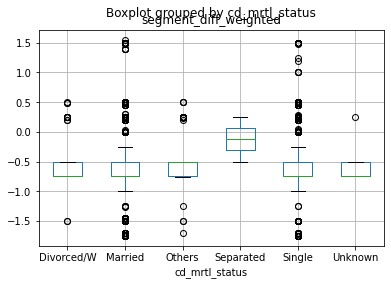

In [560]:
tmp = df_eda_dna[['cd_mrtl_status', 'segment_diff_weighted']]
tmp.loc[tmp['cd_mrtl_status'].isin(['Divorced', 'Widowed']), 'cd_mrtl_status'] = 'Divorced/W'
tmp.boxplot('segment_diff_weighted', 'cd_mrtl_status')
df_eda_dna.fillna(' ').groupby('cd_mrtl_status').count()[['BE_SEGMENT_prev']]

<ipython-input-557-f58878d0417e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['cd_state'] = tmp['cd_state'].fillna(' ')


,BE_SEGMENT_prev
cd_state,
,48
01. KLANG VALLEY,4210
02. JOHOR,1393
03. MELAKA,213
04. PAHANG,236
05. PERAK,691
06. N. SEMBILAN,251
07. TERENGGANU,148
08. PULAU PINANG,788


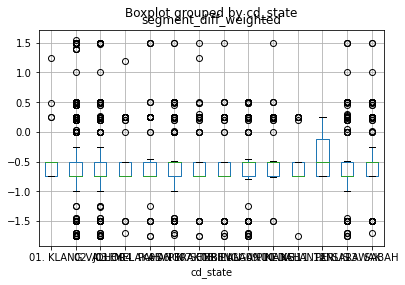

In [557]:
tmp = df_eda_dna[['cd_state', 'segment_diff_weighted']]
tmp['cd_state'] = tmp['cd_state'].fillna(' ')
tmp.boxplot('segment_diff_weighted', 'cd_state')
df_eda_dna.fillna(' ').groupby('cd_state').count()[['BE_SEGMENT_prev']]

<AxesSubplot:title={'center':'segment_diff_weighted'}, xlabel='cd_premier_cust_flg'>

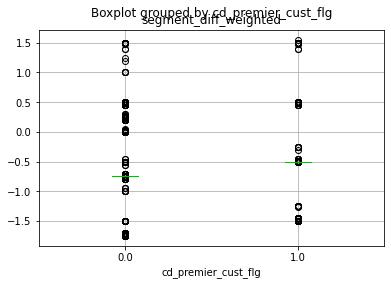

In [573]:
tmp = df_eda_dna[['cd_premier_cust_flg', 'segment_diff_weighted']]
tmp.boxplot('segment_diff_weighted', 'cd_premier_cust_flg')

In [572]:
df_premier = df_eda_dna[['cd_premier_cust_flg', 'segment_diff_weighted']]
df_premier = df_premier[~df_premier['cd_premier_cust_flg'].isna()]
df_premier['cd_premier_cust_flg'] = df_premier['cd_premier_cust_flg'].astype('int')
X = pd.get_dummies(df_premier['cd_premier_cust_flg'], prefix = 'premier')
y = df_premier['segment_diff_weighted']
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.01098781504797186

Summary - nothing useful

# Cust DNA past data

In [606]:
cols_pm = ['DP_A6M_CASA_MTHLY_WDR_CNT',
 'DP_A6M_CASA_MTHLY_WDR_AMT',
 'DP_R6M_CASA_MTHLY_WDR2DEP_AMT',
 'DP_L6M_SLP_CASA_MTHLY_WDR_AMT',
 'DP_A6M_FD_MTHLY_WDR_CNT',
 'DP_A6M_FD_MTHLY_WDR_AMT',
 'DP_R6M_FD_MTHLY_WDR2DEP_AMT',
 'DP_L6M_SLP_FD_MTHLY_WDR_AMT']

cols_resp = ['segment_diff_weighted', 'segment_diff', 'BE_SEGMENT_prev', 'BE_SEGMENT_weighted', 'BE_SEGMENT_cur']

In [607]:
df_dna = pd.read_csv('data/cust_dna.csv')
df_dna = df_dna.merge(df_comb[['id'] + cols_resp], on='id', how='right')
# df_dna = df_dna[cols_pm + cols_resp]

0.007819263756511874

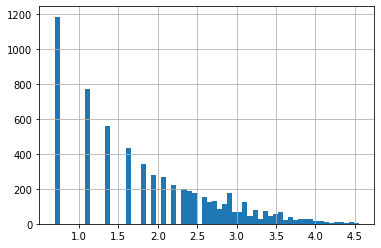

In [645]:
mask = (df_dna['DP_A6M_CASA_MTHLY_WDR_CNT'] < 100) & (df_dna['DP_A6M_CASA_MTHLY_WDR_CNT'] > 1)
np.log(df_dna['DP_A6M_CASA_MTHLY_WDR_CNT'][mask]).hist(bins=60)

X = np.log(df_dna[mask]['DP_A6M_CASA_MTHLY_WDR_CNT'])
X = pd.DataFrame(X)
y = df_dna[mask]['segment_diff_weighted']
reg = LinearRegression().fit(X, y)
reg.score(X, y)

# Transactions 

In [21]:
os.listdir('data')

['savingacct_txn.csv',
 'creditcard_txn.csv',
 'cust_past1year_snapshot.xlsx',
 'cust.csv',
 'currentacct_txn.csv',
 'cust_dna.csv',
 'cust_prev.csv']

In [98]:
df_saving = pd.read_csv('data/savingacct_txn.csv')
df_saving['D_TRANSACTION_DATE'] = pd.to_datetime(df_saving['D_TRANSACTION_DATE'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [106]:
df = df_saving
# df = df_saving[df_saving['id'] == 12359928]
df['mult'] = df['D_TRAN_TYPE'].replace({'D': 1, 'C': -1})
df['transact'] = df['mult'] * df['D_TRAN_AMOUNT']
df = df[['transact', 'D_TRANSACTION_DATE', 'id']]

tmp = pd.date_range(start='1/1/2021', end='31/12/2021')
tmp = pd.DataFrame({'transact': 0, 'D_TRANSACTION_DATE': tmp})
df = df.append(tmp).sort_values('D_TRANSACTION_DATE')
df['D_TRANSACTION_DATE'] = (df['D_TRANSACTION_DATE'] \
                            .apply(lambda x: x.value) - pd.to_datetime('1/1/2021').value) // 86400000000000
df = df.groupby('D_TRANSACTION_DATE').sum().reset_index()
df['day'] = df['D_TRANSACTION_DATE'].astype(int)
del df['D_TRANSACTION_DATE']

(array([  1.,   2.,   1.,  12.,  18.,  64., 119., 126.,  16.,   6.]),
 array([-16517.27090411, -14008.41364932, -11499.55639452,  -8990.69913973,
         -6481.84188493,  -3972.98463014,  -1464.12737534,   1044.72987945,
          3553.58713425,   6062.44438904,   8571.30164384]),
 <BarContainer object of 10 artists>)

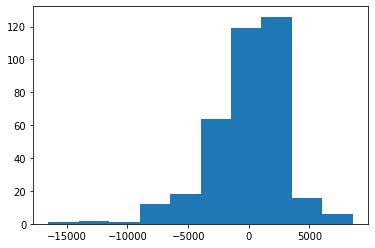

In [109]:
# window = 10
# df_rolled = df.rolling(window=window).apply(lambda x : sum(x) / window).tail(len(df) - window + 1)
plt.scatter(df['transact'] / len(df['id'].unique()))

In [102]:
df['id']

NameError: name 'nunique' is not defined

In [ ]:
df['transact'] / 

In [46]:
np.digitize(df['transact'], bins)

,transact,D_TRANSACTION_DATE
0,17000.00,2021-07-31
1,-27265.00,2021-07-30
2,608.02,2021-07-31
3,9670.00,2021-07-31
4,703.60,2021-08-31
5,-27265.00,2021-08-30
6,17000.00,2021-08-31
7,9560.00,2021-08-31
8,-27265.05,2021-09-30
9,1153.55,2021-09-30


In [35]:
df

,mult,D_TRAN_AMOUNT
0,1,17000.00
1,-1,27265.00
2,1,608.02
3,1,9670.00
4,1,703.60
5,-1,27265.00
6,1,17000.00
7,1,9560.00
8,-1,27265.05
9,1,1153.55
